In [1]:
import sys
import matplotlib
import matplotlib.pyplot as plt

from mrlattice.lattice.generate import *
from mrlattice.lattice.validate import *
from mrlattice.plotting import *

In [2]:
# this notebook requires mrlattice version:
VERSION = "0.1.5"

In [3]:
%run prepare_notebook.ipynb

The following names are now available:

<class '__main__.LatticeArrayPlotWidget'>
<class '__main__.SuperimposeLatticeArrayPlotWidget'>


In [4]:
%run 0.1.5-01_configuration_loops.ipynb
clear_output()

In [5]:
print(NewValidateLattice)

<class '__main__.NewValidateLattice'>


In [6]:
# interactive plots in notebook
# %matplotlib notebook
# open external window with plot
# %matplotlib qt
# for saving widget state
%matplotlib inline

if "inline" in matplotlib.get_backend():
    plt.rcParams["figure.figsize"] = (14, 14)
else:
    plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

# Summary

We present 3 specialized validation tests and demonstrate their usage.


# Validation of Neighbor Cells

The next set of validation tests contains 3 tests. All of them require temporal neighbors so that the outer loop over all time slices is changed to iterators over the nth and n+1st time slice. They are also specialized tests, meaning that they aren't applicable to any instance of `LatticeArray`, but only to certain derived types. These tests are marked accordingly.

This time each test is accompanied by a manually configured test lattice that should fail the test by design. We will provide a series of those invalid lattices later, when we unit test all validation tests and the test suite.

We also use a new "printable" representation of the lattice that is generated by the `mrlattice.plotting.generate_print_lattice` function. It creates a 2D numpy array where the first dimension is the number of time slices. Each time slice contains as many elements as the spatial dimension of the lattice in finest units. Each element is a number that represents the resolution of the cell that would include that spacetime point. This new representation is used for one of the tests.

### Diagonal Borders

This test finally validates the staircase shaped diagonal borders that caused a lot of headake to implement. A correct "straight edge" follows from the simple rule, that for two neighboring time slices the boundary between two regions can only shift by 1 cell of the coarser region or stay the same. Testing this condition can be easily done by comparing the difference of the number of cells for the same region for neighboring time slices. For the region with finest resolution the condition translates to a shift of two cells, as can easily be understood by looking at test lattices.

It should be noted, that this test is expected to fail for instances of `SuperimposeLatticeArray`. For that type the double cell tip will change the number of cells by 2 (4 for finest region). In the demonstrations at the end of this notebook such an expected failure is recorded.

In [7]:
def test_diagonal_borders(lattice):
    """Test diagonal borders staircase edge."""
    # this test is designed for the base LatticeArray
    # and requires the same number of regions per time slice
    # other derived types may not give correct results
    
    for t,(ts1, ts2) in enumerate(zip(lattice.array[:-1], lattice.array[1:])):
        diff = [ r1[-1] - r2[-1] for r1, r2 in zip(ts1, ts2) ]
        
        for i,d in enumerate(diff):
            # finest region is always 2x
            dc = 2/min(2, ts1[i][1])
            if d not in [-dc, 0, dc]:
                raise ValidationError(
                    f"Time slices {t} and {t+1} have discontinuous diagonal borders "
                    f"for regions:\n{ts1[i]} and {ts2[i]}",
                    "test_diagonal_borders")

Test test_diagonal_borders failed validation!
Time slices 3 and 4 have discontinuous diagonal borders for regions:
(1, 1, 14) and (1, 1, 10)



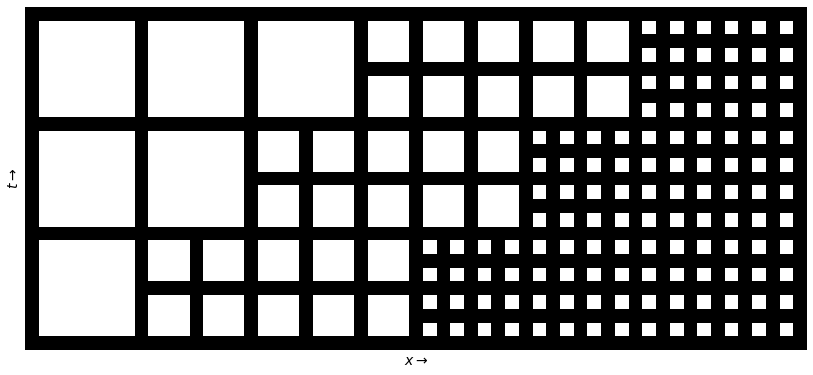

In [8]:
# a test lattice with invalid diagonal borders
invalid_lattice = LatticeArray()
invalid_lattice._array = [
    ((4, 4, 1), (2, 2, 5), (1, 1, 14)),
    ((4, 4, 1), (2, 2, 5), (1, 1, 14)),
    ((4, 4, 1), (2, 2, 5), (1, 1, 14)),
    ((4, 4, 1), (2, 2, 5), (1, 1, 14)),
    ((4, 4, 2), (2, 2, 5), (1, 1, 10)),
    ((4, 4, 2), (2, 2, 5), (1, 1, 10)),
    ((4, 4, 2), (2, 2, 5), (1, 1, 10)),
    ((4, 4, 2), (2, 2, 5), (1, 1, 10)),
    ((4, 4, 3), (2, 2, 5), (1, 1, 6)),
    ((4, 4, 3), (2, 2, 5), (1, 1, 6)),
    ((4, 4, 3), (2, 2, 5), (1, 1, 6)),
    ((4, 4, 3), (2, 2, 5), (1, 1, 6))
]
plot_mesh(generate_plot_lattice(invalid_lattice.array), alpha_bg=True)
try:
    test_diagonal_borders(invalid_lattice)
except ValidationError as e:
    print(e.args[0])

The following test lattices exhibit the problem, that spatial cell boundaries don't continue between time slices. This happens, if a coarser region is sandwiched by two finer regions and the finer regions only change by 1 cell in size. The two test lattices shown below are of the same shape but differently scaled. The first lattice contains regions with resolutions 1 and 2, whereas the second lattice contains 2 and 4. The `test_diagonal_borders` test correctly identifies the problem only for the first lattice. It is therefore not suited to test against lattice problems of this kind. However, this kind of configuration doesn't emerge from diagonal borders lattices anyway.

Test test_diagonal_borders failed validation!
Time slices 7 and 8 have discontinuous diagonal borders for regions:
[1, 1, 11] and [1, 1, 12]

Test test_diagonal_borders failed validation!
Time slices 3 and 4 have discontinuous diagonal borders for regions:
[2 2 5] and [2 2 7]



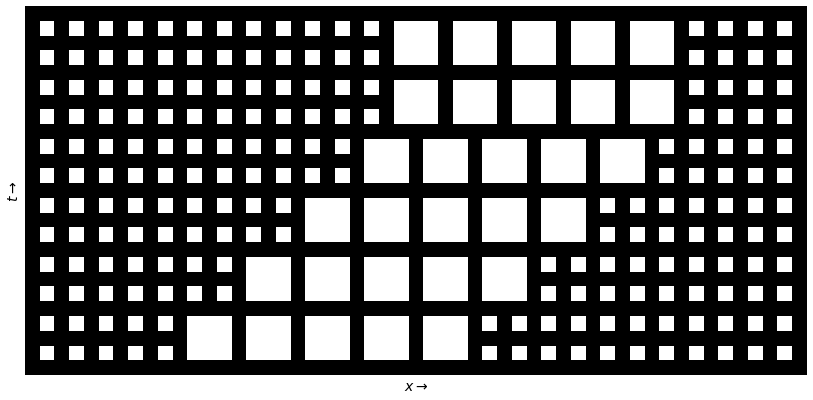

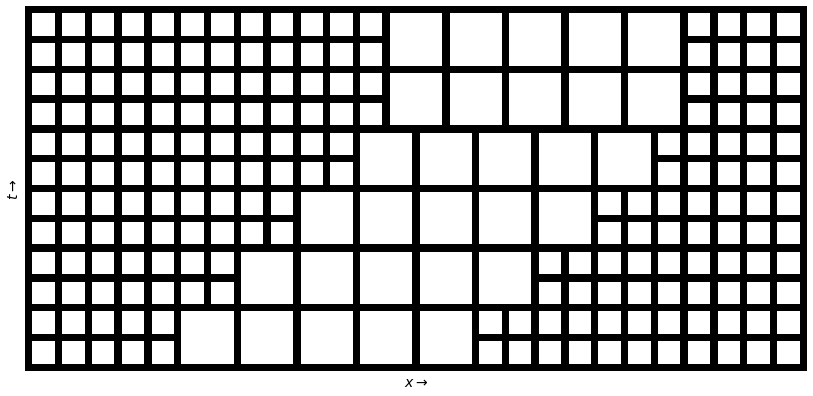

In [9]:
# a test lattice with invalid diagonal borders
invalid_lattice2 = LatticeArray()
invalid_lattice2._array = [
    ([1, 1, 5], [2, 2, 5], [1, 1, 11]),
    ([1, 1, 5], [2, 2, 5], [1, 1, 11]),
    ([1, 1, 7], [2, 2, 5], [1, 1, 9]),
    ([1, 1, 7], [2, 2, 5], [1, 1, 9]),
    ([1, 1, 9], [2, 2, 5], [1, 1, 7]),
    ([1, 1, 9], [2, 2, 5], [1, 1, 7]),
    ([1, 1, 11], [2, 2, 5], [1, 1, 5]),
    ([1, 1, 11], [2, 2, 5], [1, 1, 5]),
    ([1, 1, 12], [2, 2, 5], [1, 1, 4]),
    ([1, 1, 12], [2, 2, 5], [1, 1, 4]),
    ([1, 1, 12], [2, 2, 5], [1, 1, 4]),
    ([1, 1, 12], [2, 2, 5], [1, 1, 4]),
]
plot_mesh(generate_plot_lattice(invalid_lattice2.array), alpha_bg=True)
try:
    test_diagonal_borders(invalid_lattice2)
except ValidationError as e:
    print(e.args[0])

# now scaled by 2
invalid_lattice2._array = np.repeat(invalid_lattice2.array, repeats=2, axis=0)
for ts in invalid_lattice2.array:
    for r in ts:
        r[1] *=2
        r[0] *=2
plot_mesh(generate_plot_lattice(invalid_lattice2.array), alpha_bg=True)
try:
    test_diagonal_borders(invalid_lattice2)
except ValidationError as e:
    print(e.args[0])

### Temporal Neighbors

In the previous notebook we verified that spatial neighbors never differ in resolution by a factor larger than 2x. We now extend this condition to temporal neighbors. Hereby, we also take into account diagonal neighbors, as illustrated by the "invalid" lattice example below.  
For the validation test we work with the lattice in a differnt form as returned by `generate_print_lattice` explained above. This allows to simply divide time slices by each other and compare the quotients with 1/2, 1 or 2 for the allowed changes of resolution.

In [10]:
def test_temporal_neighbors(lattice):
    """Test if temporal neighbors' resolution only differ by 2x."""
    
    plattice = generate_print_lattice(lattice.array)
    for t,(ts1, ts2) in enumerate(zip(plattice[:-1], plattice[1:])):
        msg = list()
        
        # test direct temporal neighbor
        res = np.isin((ts1 / ts2), [1/2, 1, 2])
        res = np.where(res, 0, 1).nonzero()[0]
        if res.size:
            msg.append(f"{res} and {res}\n")
           
        # test left diag temporal neighbor
        res = np.isin((ts1[1:]/ts2[:-1] ), [1/2, 1, 2])
        res = np.where(res, 0, 1).nonzero()[0]
        if res.size:
            msg.append(f"{res+1} and {res}\n")

        # test right diag temporal neighbor
        res = np.isin((ts1[:-1]/ts2[1:] ), [1/2, 1, 2])
        res = np.where(res, 0, 1).nonzero()[0]
        if res.size:
            msg.append(f"{res} and {res+1}\n")
    
        if msg:
            raise ValidationError(
                f"Time slices {t} and {t+1} have temproal neighbors that differ "
                "more than 2x in resolution at positions [finest units]:\n"
                f"{''.join(msg)}",
                "test_temporal_neighbors")

[[1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 1 1 1 1]
 [2 2 2 2 2 2 2 2 1 1 1 1]
 [2 2 2 2 2 2 2 2 1 1 1 1]
 [2 2 2 2 2 2 2 2 1 1 1 1]
 [4 4 4 4 4 4 4 4 2 2 2 2]
 [4 4 4 4 4 4 4 4 2 2 2 2]
 [4 4 4 4 4 4 4 4 2 2 2 2]
 [4 4 4 4 4 4 4 4 2 2 2 2]]
Test test_temporal_neighbors failed validation!
Time slices 3 and 4 have temproal neighbors that differ more than 2x in resolution at positions [finest units]:
[7] and [8]




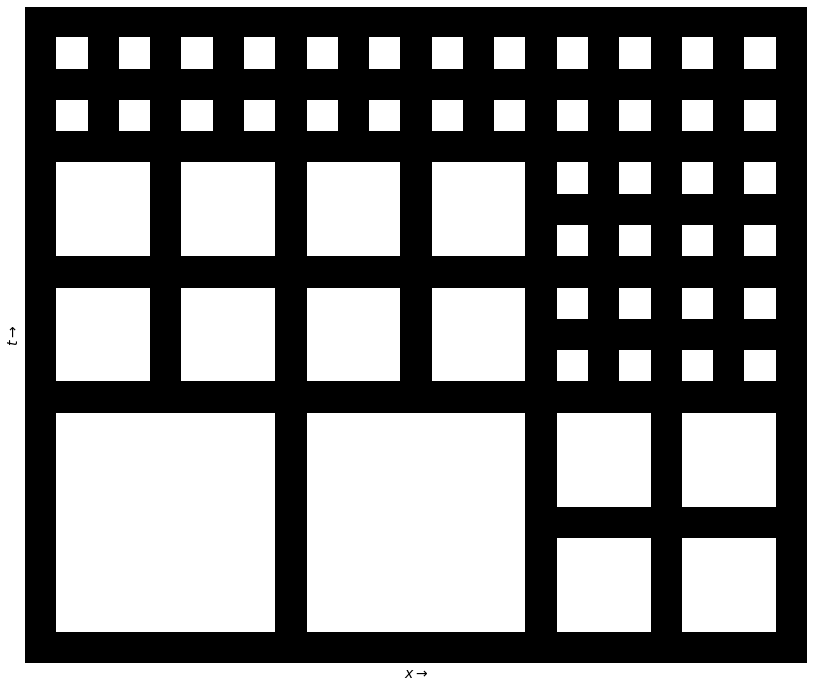

In [11]:
# a test lattice with invalid diag neighbors
invalid_diag_lattice = LatticeArray()
invalid_diag_lattice._array = [
    [(4, 4, 2), (2, 2, 2)],
    [(4, 4, 2), (2, 2, 2)],
    [(4, 4, 2), (2, 2, 2)],
    [(4, 4, 2), (2, 2, 2)],
    [(2, 2, 4), (1, 1, 4)],
    [(2, 2, 4), (1, 1, 4)],
    [(2, 2, 4), (1, 1, 4)],
    [(2, 2, 4), (1, 1, 4)],
    [(1, 1, 12)],
    [(1, 1, 12)],
]
print(np.flipud(generate_print_lattice(invalid_diag_lattice.array)))
plot_mesh(generate_plot_lattice(invalid_diag_lattice.array), alpha_bg=True)
try:
    test_temporal_neighbors(invalid_diag_lattice)
except ValidationError as e:
    print(e.args[0])

### Double Cell Tips

Finally, we validate if cusps in the lattice array have double cell tips in the spatial direction. This test exploits the fact, that for `SuperimposeLatticeArrays` the cusp will form spatially centered. By comparing the number of regions between neighboring time slices we can identify a change of 2 with the insertion of a new region. We then test if the central region of the changed time slice (the double cell tip) contains exaclty 2 cells. This test only works for cusps sandwitched between two regions of finer resolution, as generated by `SuperimposeLatticeArray`. There can also never be a "double cell tip" with cells of the finest resolution for `SuperimposeLatticeArrays`.

This test will pass for `LatticeArray` instances, but won't give any usefull information.

In [12]:
def test_double_cell_tips(lattice):
    """Test if cusps only have double cell tips in spatial direction."""
    # this test is designed for SuperimposeLatticeArray
    # and test cusps with double cell tips
    # other lattices without cups may not give correct results
    
    def check_dct(t, time_slice):
        # symmetry argument
        faulty_reg_idx = len(time_slice)//2
        if time_slice[faulty_reg_idx][-1] != 2:
            raise ValidationError(
                f"Time slices {t} and {t+1} contain a cusp that "
                "has no double cell tip. Region:\n"
                f"{time_slice[faulty_reg_idx]} number {faulty_reg_idx}",
                "test_double_cell_tips")
  
    for t,(ts1, ts2) in enumerate(zip(lattice.array[:-1], lattice.array[1:])):
        r_diff = len(ts1) - len(ts2)
        if r_diff == 2:
            check_dct(t, ts1)
        elif r_diff == -2:
            check_dct(t, ts2)
        elif r_diff == 0:
            continue
        else:
            raise ValidationError(
                f"The change in regions from time slice {t} to {t+1} "
                "couldn't be identified as a cusp.",
                "test_double_cell_tips")

Test test_double_cell_tips failed validation!
Time slices 15 and 16 contain a cusp that has no double cell tip. Region:
(4, 4, 3) number 2



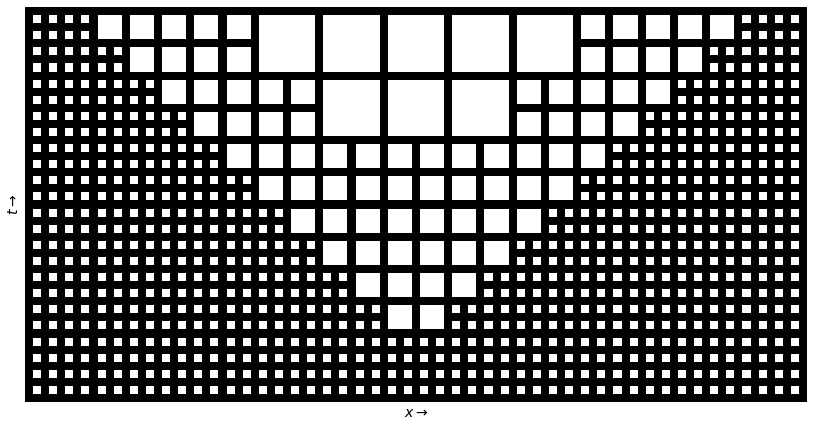

In [13]:
# test lattice for double cell tips
invalid_dct = SuperimposeLatticeArray()
invalid_dct._array = [
    ((1, 1, 48),), ((1, 1, 48),), ((1, 1, 48),), ((1, 1, 48),),
    ((1, 1, 22), (2, 2, 2), (1, 1, 22)),
    ((1, 1, 22), (2, 2, 2), (1, 1, 22)),
    ((1, 1, 20), (2, 2, 4), (1, 1, 20)),
    ((1, 1, 20), (2, 2, 4), (1, 1, 20)),
    ((1, 1, 18), (2, 2, 6), (1, 1, 18)),
    ((1, 1, 18), (2, 2, 6), (1, 1, 18)),
    ((1, 1, 16), (2, 2, 8), (1, 1, 16)),
    ((1, 1, 16), (2, 2, 8), (1, 1, 16)),
    ((1, 1, 14), (2, 2, 10), (1, 1, 14)),
    ((1, 1, 14), (2, 2, 10), (1, 1, 14)),
    ((1, 1, 12), (2, 2, 12), (1, 1, 12)),
    ((1, 1, 12), (2, 2, 12), (1, 1, 12)),
    ((1, 1, 10), (2, 2, 4), (4, 4, 3), (2, 2, 4), (1, 1, 10)),
    ((1, 1, 10), (2, 2, 4), (4, 4, 3), (2, 2, 4), (1, 1, 10)),
    ((1, 1, 8), (2, 2, 5), (4, 4, 3), (2, 2, 5), (1, 1, 8)),
    ((1, 1, 8), (2, 2, 5), (4, 4, 3), (2, 2, 5), (1, 1, 8)),
    ((1, 1, 6), (2, 2, 4), (4, 4, 5), (2, 2, 4), (1, 1, 6)),
    ((1, 1, 6), (2, 2, 4), (4, 4, 5), (2, 2, 4), (1, 1, 6)),
    ((1, 1, 4), (2, 2, 5), (4, 4, 5), (2, 2, 5), (1, 1, 4)),
    ((1, 1, 4), (2, 2, 5), (4, 4, 5), (2, 2, 5), (1, 1, 4)),
]
plot_mesh(generate_plot_lattice(invalid_dct.array), alpha_bg=True)
try:
    test_double_cell_tips(invalid_dct)
except ValidationError as e:
    print(e.args[0])

## Superimposed Test Lattice

In [14]:
FIXED_WIDTH_PROPS = {
    "scheme":"fixed_width",
    "coarse_steps":4,
    "borders_width":30,
    "buffer":3,
    "finest_width":16,
    "repeat":9,
}
sup_lattice = SuperimposeLatticeArray(**FIXED_WIDTH_PROPS)
sup_lattice.generate_array()
prop_sort = [
    "buffer",
    "coarse_steps",
    "borders_width",
    "finest_width",
    "repeat",
]
sup_valid = NewValidateLattice(sup_lattice, sorted_props=prop_sort)

SuperimposeLatticeArrayPlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Number o…

Output()

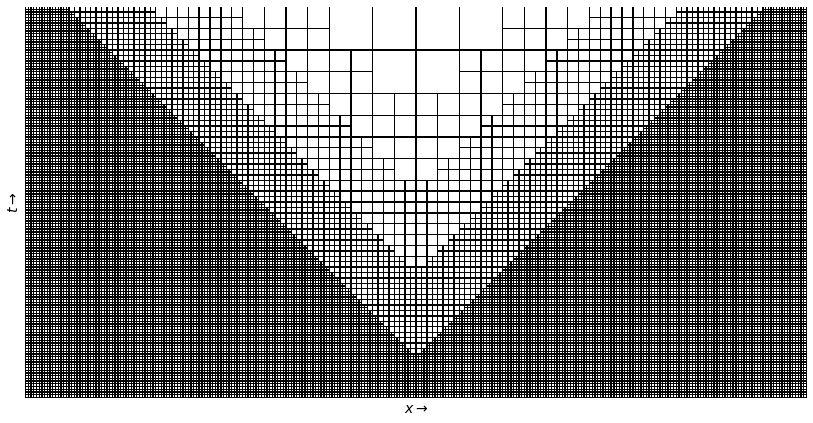

In [15]:
sup = SuperimposeLatticeArrayPlotWidget(lattice=sup_lattice)
sup.alpha_bg.value = True
sup._plot_button_on_click()
display(sup)

## Diagonal Borders Test Lattice

In [16]:
FIXED_WIDTH_PROPS = {
    "scheme":"fixed_width",
    "coarse_steps":4,
    "borders_width":30,
    "buffer":3,
    "finest_width":7,
    "repeat":4,
}
diag_lattice = LatticeArray(**FIXED_WIDTH_PROPS)
diag_lattice.generate_array()
prop_sort = [
    "buffer",
    "coarse_steps",
    "borders_width",
    "finest_width",
    "repeat",
]
diag_valid = NewValidateLattice(diag_lattice, sorted_props=prop_sort)

LatticeArrayPlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Number of Borders b…

Output()

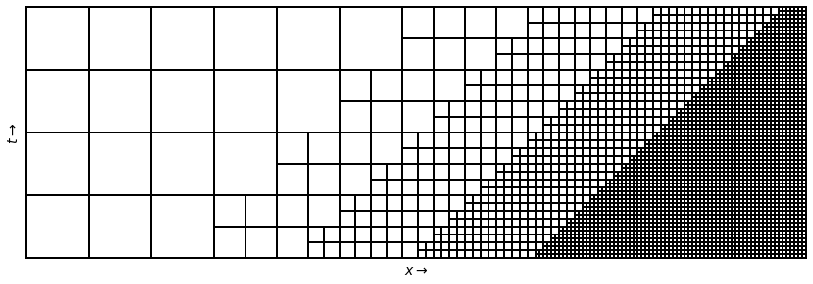

In [17]:
diag = LatticeArrayPlotWidget(lattice=diag_lattice)
diag.alpha_bg.value = True
diag._plot_button_on_click()
display(diag)

## Example Validation Test Execution

In [18]:
# diag borders lattice
diag_valid.add_test("test temporal", test_temporal_neighbors)
diag_valid.add_test("test diag", test_diagonal_borders)
diag_valid.add_test("test dct", test_double_cell_tips)
diag_valid(stdout=sys.stdout)

test_dct
Test if cusps only have double cell tips in spatial direction. ... 
	PASSED.
test_diag
Test diagonal borders staircase edge. ... 
	PASSED.
test_temporal
Test if temporal neighbors' resolution only differ by 2x. ... 
	PASSED.


----------------------------------------------------------------------
Ran 3 tests:
	3 passed

PASSED!


True

In [19]:
# superimposed lattice
sup_valid.add_test("test temporal", test_temporal_neighbors)
sup_valid.add_test("test diag", test_diagonal_borders)
sup_valid.add_test("test dct", test_double_cell_tips)
sup_valid(stdout=sys.stdout)

test_dct
Test if cusps only have double cell tips in spatial direction. ... 
	PASSED.
test_diag
Test diagonal borders staircase edge. ... 
	FAILED!
test_temporal
Test if temporal neighbors' resolution only differ by 2x. ... 
	PASSED.


----------------------------------------------------------------------
Ran 3 tests:
	2 passed
	1 failed

FAILED!



FAIL: test_diag
Test diagonal borders staircase edge.
<SuperimposeLatticeArray(scheme=fixed_width, coarse_steps=4, borders_width=30, buffer=3, finest_width=16, repeat=9 at 0x7f3d462429a0>
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/home/simple/Documents/adaptive_mesh/multi-resolution_lattice/src/mrlattice/lattice/validate.py", line 268, in __call__
    getattr(self, test + "_func")(self.lattice, *args, **kwargs)
  File "<ipython-input-7-7505beb86e3f>", line 14, in test_diagonal_borders
    raise ValidationError(
mrlattice.lattice.validate.ValidationError: Test test_diagonal_borders failed validation!
Time slices 15 and 16 have discontinuous diagonal borders for regions:
(1, 1, 288) and (1, 1, 142)




False